# Video stream train

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

from keras.layers.core import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [18]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


## Dataset creation

Nico 
0: angry
1: calm
2: disgust
3: fear
4: happy
5: sad
6: surprise

In [19]:
emotions = {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'}
emotional_intensity = {1:'normal', 2:'strong'}

dataset_path = "Datasets/RAVDESS_frames/"

height_orig = 224
width_orig = 398
height_targ = 224
width_targ = 224

batch_size = 128
num_classes = len(emotions)

val_actors = ['21', '22']
test_actors = ['23', '24']

In [20]:
filenames_train = [] # train
filenames_val = [] # validation

for (dirpath, dirnames, fn) in os.walk(dataset_path):
    if fn != []:
        if any(act in dirpath for act in (test_actors+val_actors))==False:  # select only train actors
            path = [os.path.join(dirpath, elem) for elem in fn]
            label = [int(fn[0].split('-')[2]) - 1] * len(fn)
            filenames_train.append(list(zip(path, label)))
        if any(act in dirpath for act in val_actors):                       # select only validation actors
            path = [os.path.join(dirpath, elem) for elem in fn]
            label = [int(fn[0].split('-')[2]) - 1] * len(fn)
            filenames_val.append(list(zip(path, label)))

In [21]:
# image = tf.io.read_file(filenames_train[0][0][0])
# image = tf.image.decode_jpeg(image, channels=3)
# image = tf.image.convert_image_dtype(image, dtype=tf.float16)
# image = tf.image.resize(image, [height_orig, width_orig])

# image = image.numpy()
# for i, elem in enumerate(image):
#     for j, val in enumerate(elem):
#         if np.sum(val) > 2.7:
#             image[i][j] = np.array([0, 0, 0])
# image = tf.convert_to_tensor(image)

# plt.imshow(image)

In [22]:
def sampling(list, num_frames_desired):
    tot = []
    for elem in list:
        sampled_list = random.sample(elem, num_frames_desired)
        tot += sampled_list
    return(tot)

def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    image = tf.image.resize(image, [height_orig, width_orig])
    print('shape frames:', image.shape)
    return image

def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000) # serve?
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def load_dataset(filenames, batch_size):
    frames_per_vid = min([len(elem) for elem in filenames])     # number of frames per clip in order to have balanced classes
    print("frames per video:", frames_per_vid) 

    filenames_sampled = sampling(filenames, frames_per_vid)
    random.shuffle(filenames_sampled)

    zipped = [list(t) for t in zip(*filenames_sampled)]

    names = zipped[0]
    labels = zipped[1]

    names = tf.data.Dataset.from_tensor_slices(names)
    images = names.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    labels = [elem for elem in labels]
    labels = tf.data.Dataset.from_tensor_slices(labels)

    ds = tf.data.Dataset.zip((images, labels))
    ds = configure_for_performance(ds)

    frame_number = len(filenames_sampled)
    step_per_epoch = frame_number // batch_size
    print('frames number:', frame_number, '\nbatch size:', batch_size, '\nbatch number:', step_per_epoch)
    return ds, step_per_epoch

In [23]:
train_ds, step_per_epoch_train = load_dataset(filenames_train, batch_size)

frames per video: 23
shape frames: (224, 398, 3)
frames number: 27600 
batch size: 128 
batch number: 215


In [24]:
val_ds, step_per_epoch_val = load_dataset(filenames_val, batch_size)

frames per video: 28
shape frames: (224, 398, 3)
frames number: 3360 
batch size: 128 
batch number: 26


(224, 398, 3)
fear


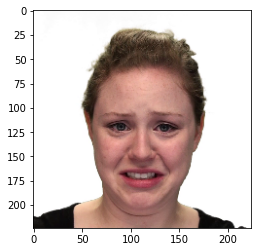

In [32]:
a = train_ds.unbatch().take(1)

for elem in a:
    o = tf.image.resize_with_crop_or_pad(elem[0], height_targ, width_targ)
    
    print(elem[0].shape)
    print(emotions[int(elem[1])])
plt.imshow(o)

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.CenterCrop(height_targ, width_targ),
    # layers.RandomBrightness(0.5), # da verificare
    # layers.RandomContrast(0.5) # da verificare
    # layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=(-0.1, 0.1))
])

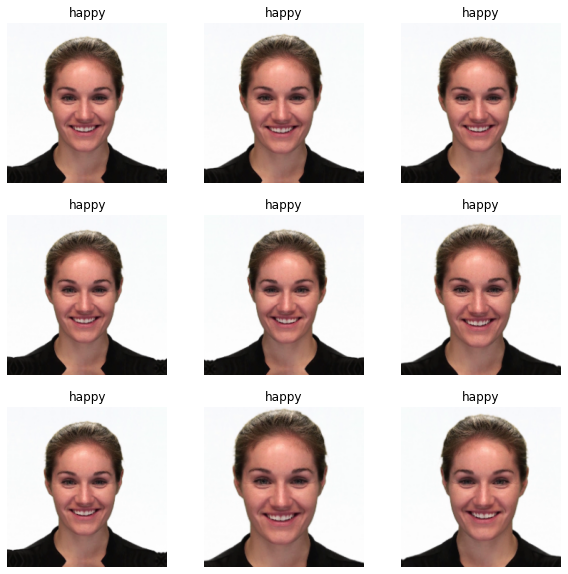

In [11]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    # print(labels)
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0])
        plt.title(emotions[int(labels[0])])
        plt.axis("off")

## Transfer Learning ResNet50

In [12]:
checkpoint_filepath = './Models/video_model{epoch:02d}-{val_loss:.2f}.hdf5'

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_sparse_categorical_accuracy", factor=0.5, patience=2, verbose=1)
early_stop = keras.callbacks.EarlyStopping( monitor="val_sparse_categorical_accuracy", patience=4, verbose=1, restore_best_weights=True)
save_best = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                            monitor='val_sparse_categorical_accuracy',
                                            mode='max',
                                            save_best_only=True)

In [13]:
version = 3
arc = 'resnet'
epochs_train = 10
epochs_tune = 10
lr_train = 0.05
lr_tune = 0.00001
momentum = 0.5

In [14]:
pretrained_model = keras.applications.ResNet50(include_top=False,
                                                input_shape=(height_targ, width_targ, 3),
                                                weights='imagenet',
                                                pooling='avg')
pretrained_model.trainable = False


inputs = keras.layers.Input(shape=(height_orig, width_orig, 3))

x = data_augmentation(inputs)

x = pretrained_model(x, training=False) # `training=False` important for fine-tuning
# x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dropout(0.2)(x) 
x = keras.layers.Dense(512, activation='relu')(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 398, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24,640,904
Trainable params: 1,053,192
Non-trainable params: 23,587,712
_________________________________________________________________


### Train top layer

In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_train),
    # optimizer=keras.optimizers.SGD(learning_rate=learningrate, momentum=momentum)
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[keras.metrics.sparse_categorical_accuracy, keras.metrics.sparse_top_k_categorical_accuracy],
)


history = model.fit(train_ds,
                    epochs=epochs_train,
                    validation_data=val_ds,
                    batch_size=batch_size,
                    steps_per_epoch=step_per_epoch_train,
                    validation_steps=step_per_epoch_val,
                    # callbacks=[reduce_lr, early_stop, save_best],
                    # callbacks=[reduce_lr, save_best],
                    verbose=1)

Epoch 1/10
209/215 [============================>.] - ETA: 4s - loss: 3.4107 - sparse_categorical_accuracy: 0.1296 - sparse_top_k_categorical_accuracy: 0.6651

KeyboardInterrupt: 

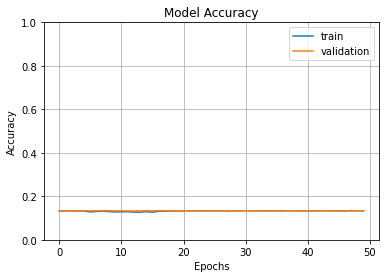

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
# plt.savefig('./Report/Plots/resnet1_2.png')
plt.show()

### Fine tuning

In [ ]:
pretrained_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 398, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24,640,904
Trainable params: 24,587,784
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_tune),
    # optimizer=keras.optimizers.SGD(learning_rate=learningrate, momentum=momentum)
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[keras.metrics.sparse_categorical_accuracy, keras.metrics.sparse_top_k_categorical_accuracy],
)

history_fine = model.fit(train_ds,
                    epochs=epochs_tune,
                    validation_data=val_ds,
                    batch_size=batch_size,
                    steps_per_epoch=step_per_epoch_train,
                    validation_steps=step_per_epoch_val,
                    callbacks=[reduce_lr, save_best],
                    # callbacks=[reduce_lr, early_stop, save_best],
                    verbose=1)

Epoch 1/10


ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[64,56,56,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/resnet50/conv2_block1_3_conv/BiasAdd-0-0-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_149547]

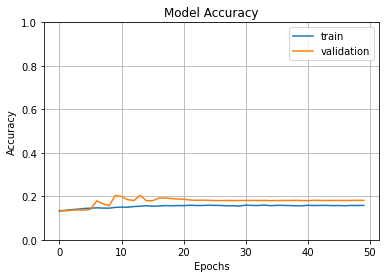

In [ ]:
fig1 = plt.gcf()
plt.plot(history_fine.history['sparse_categorical_accuracy'])
plt.plot(history_fine.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
# plt.savefig('./Report/Plots/resnet1_2.png')
plt.show()

## Prove

In [ ]:
# image = tf.io.read_file(filenames_train[0][0][0])
# image = cv2.imread(filenames_train[0][0][0], cv2.IMREAD_COLOR)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = image.astype(float) / 255

# height, width, _ = image.shape

# for i in range(height):
#     for j in range(width):
#         if image[i, j].sum() > 2.8:
#             image[i, j] = [0, 0, 0]

# # image = tf.image.convert_image_dtype(image, dtype=tf.float16)
# image = tf.image.resize(image, [height_orig, width_orig])
# plt.imshow(image)
# # image

# tf.data.Dataset.from_tensor_slices(filenames_train)
